## Архитектуры нейронок для разных задач

In [ ]:
# 1. Координаты X, Y, TVD1 и TVD2 лежат отдельными листами в .xlsx файле
# 2. Файлов .tfrecord не пугаться, в деталях коммита на всякий указал как открывать такие. 
# Там 4 таких файла уже в порядке следования дат, для нефти, воды, пластового и забойного.
# Каждый тензор размерности [121,6,6]. 
# 3. Чтобы узнать какой дате соответствует индекс в тензоре, можно заюзать файл Dates_processed.csv.
# Загружаете как датафрейм и запрашиваете по индексу строки, получаете дату.

In [1]:
# imports 

import tensorflow as tf
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    LSTM,
    TimeDistributed,
    Input,
    Concatenate,
)
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
# specify your directory where files are located 
# tensors loading

files_dir = '../data/processed/'
loaded_tensors = dict()
for file in [x for x in os.listdir(files_dir) if x.endswith("tfrecord")]:
    serialized_tensor = tf.io.read_file(os.path.join(files_dir,file))
    loaded_tensors[file] = tf.io.parse_tensor(serialized_tensor, out_type=tf.float32)

# coordinates loading 
df_coords = pd.read_excel(os.path.join(files_dir,"Coordinates_processed.xlsx"),sheet_name=['X','Y','TVD1','TVD2'],header=None)
df_X_Y = pd.DataFrame({col: list(zip(df_coords["X"][col], df_coords["Y"][col])) for col in  df_coords["X"].columns})
df_TVD = pd.DataFrame({col: list(zip(df_coords["TVD1"][col], df_coords["TVD2"][col])) for col in  df_coords["TVD1"].columns})

# time loading 
time_sequence = pd.read_csv(os.path.join(files_dir,"Dates_processed.csv"))

### Без координат

Oil data shape: (121, 6, 6, 1)
Water data shape: (121, 6, 6, 1)
Reservoir pressure data shape: (121, 6, 6, 1)
Bottomhole pressure data shape: (121, 6, 6, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - loss: 8990.1172 - val_loss: 6358.4849
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 8839.1250 - val_loss: 6318.2178
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 8750.1572 - val_loss: 6279.6514
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 8725.4707 - val_loss: 6216.2300
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 8714.4092 - val_loss: 6197.3760
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 8685.2959 - val_loss: 6181.4829
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 8670.1816 - val_loss: 6170.6865
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 8658.8486 - val_loss: 6152.4893
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 8643.7588 - val_loss: 6131.4385
Epoch 10/200
1/1 ━━━━━━━━

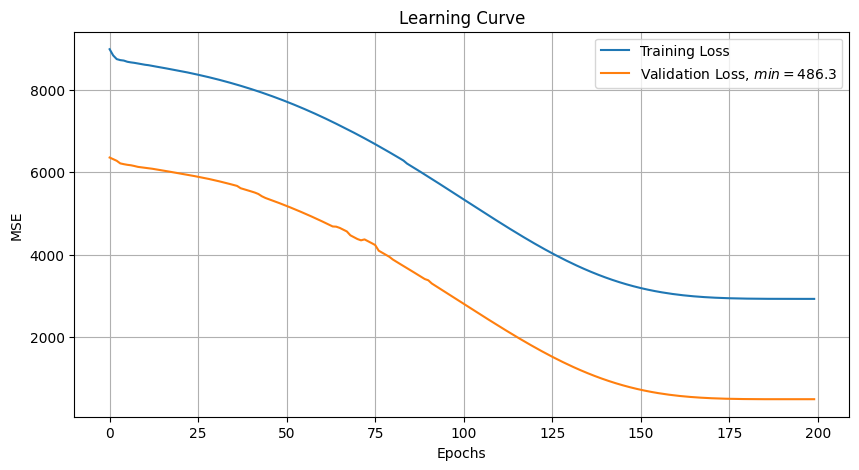

In [3]:
# Параметры
total_time_steps = 121  # Общее количество временных точек
train_time_steps = 84   # Количество временных точек для обучения (до 2027 года)
test_time_steps = total_time_steps - train_time_steps  # Количество временных точек для тестирования

map_height = 6    # Высота карты (матрицы)
map_width = 6     # Ширина карты (матрицы)
batch_size = 1    # Размер пакета

# Входы для обучающей модели
input_oil_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_oil')
input_water_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_water')
input_reservoir_pressure_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_reservoir_pressure')
input_bottomhole_pressure_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure')

# Входы для тестовой модели
input_oil_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_oil')
input_water_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_water')
input_reservoir_pressure_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_reservoir_pressure')
input_bottomhole_pressure_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure')

# Dense для каждого вида данных
def create_dense(input_tensor):
    x = TimeDistributed(Dense(256, activation='relu'))(input_tensor)
    x = TimeDistributed(Dense(128, activation='relu'))(x)
    x = TimeDistributed(Dense(64, activation='relu'))(x)
    x = TimeDistributed(Flatten())(x)
    return x

# Модель для обучения
dense_oil_train = create_dense(input_oil_train)
dense_water_train = create_dense(input_water_train)
dense_reservoir_pressure_train = create_dense(input_reservoir_pressure_train)
dense_bottomhole_pressure_train = create_dense(input_bottomhole_pressure_train)

merged_dense_train = Concatenate(axis=-1)([dense_oil_train, dense_water_train, dense_reservoir_pressure_train, dense_bottomhole_pressure_train])
lstm_out_train = LSTM(64, return_sequences=False)(merged_dense_train)
dense_out_train = Dense(32, activation='relu')(lstm_out_train)
dense_out_train = Dense(16, activation='relu')(dense_out_train)
output_train = Dense(1, activation='linear', name='output')(dense_out_train)

model_train = Model(inputs=[input_oil_train, input_water_train, input_reservoir_pressure_train, input_bottomhole_pressure_train], outputs=output_train)
model_train.compile(optimizer='adam', loss='mse')

# Модель для тестирования
dense_oil_test = create_dense(input_oil_test)
dense_water_test = create_dense(input_water_test)
dense_reservoir_pressure_test = create_dense(input_reservoir_pressure_test)
dense_bottomhole_pressure_test = create_dense(input_bottomhole_pressure_test)

merged_dense_test = Concatenate(axis=-1)([dense_oil_test, dense_water_test, dense_reservoir_pressure_test, dense_bottomhole_pressure_test])
lstm_out_test = LSTM(128, return_sequences=False)(merged_dense_test)
dense_out_test = Dense(64, activation='relu')(lstm_out_test)
dense_out_test = Dense(32, activation='relu')(dense_out_test)
output_test = Dense(1, activation='linear', name='output')(dense_out_test)

model_test = Model(inputs=[input_oil_test, input_water_test, input_reservoir_pressure_test, input_bottomhole_pressure_test], outputs=output_test)
model_test.compile(optimizer='adam', loss='mse')

# Загрузка данных из тензоров
oil_data = np.expand_dims(loaded_tensors['debit_neft_series.tfrecord'].numpy(), axis=-1)
water_data = np.expand_dims(loaded_tensors['debit_water_series.tfrecord'].numpy(), axis=-1)
reservoir_pressure_data = np.expand_dims(loaded_tensors['debit_plast_pressure_series.tfrecord'].numpy(), axis=-1)
bottomhole_pressure_data = np.expand_dims(loaded_tensors['debit_zaboy_pressure_series.tfrecord'].numpy(), axis=-1)

# Проверка форм данных
print("Oil data shape:", oil_data.shape)
print("Water data shape:", water_data.shape)
print("Reservoir pressure data shape:", reservoir_pressure_data.shape)
print("Bottomhole pressure data shape:", bottomhole_pressure_data.shape)

# Убедимся, что формы данных совпадают с ожидаемой формой
oil_data = oil_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
water_data = water_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
reservoir_pressure_data = reservoir_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
bottomhole_pressure_data = bottomhole_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))

# Разделим данные на обучающую и тестовую выборки
oil_train = oil_data[:, :train_time_steps, :, :, :]
water_train = water_data[:, :train_time_steps, :, :, :]
reservoir_pressure_train = reservoir_pressure_data[:, :train_time_steps, :, :, :]
bottomhole_pressure_train = bottomhole_pressure_data[:, :train_time_steps, :, :, :]

oil_test = oil_data[:, test_time_steps:, :, :, :]
water_test = water_data[:, test_time_steps:, :, :, :]
reservoir_pressure_test = reservoir_pressure_data[:, test_time_steps:, :, :, :]
bottomhole_pressure_test = bottomhole_pressure_data[:, test_time_steps:, :, :, :]

# Дебит нефти для обучения и тестирования
output_train = oil_data[:, :train_time_steps, map_height//2, map_width//2, 0].reshape((batch_size, train_time_steps, 1))
output_test = oil_data[:, train_time_steps:, map_height//2, map_width//2, 0].reshape((batch_size, test_time_steps, 1))

# Обучение модели
history = model_train.fit(
    [oil_train, water_train, reservoir_pressure_train, bottomhole_pressure_train],
    output_train, 
    epochs=200,
    validation_data=([oil_test, water_test, reservoir_pressure_test, bottomhole_pressure_test], output_test)
)

# Построение кривых обучения
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label=f'Validation Loss, $min={round(np.min(history.history["val_loss"]), 1)}$')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid(visible=True, which='major')
plt.legend()
plt.show()

In [63]:
preds = []
for step in range(oil_test.shape[1]):
    step_data = [
        oil_test[:, step, :, :, :],
        water_test[:, step, :, :, :],
        reservoir_pressure_test[:, step, :, :, :],
        bottomhole_pressure_test[:, step, :, :, :]
    ]
    step_pred = model_train.predict(step_data)
    preds.append(step_pred)
preds

ValueError: Input 0 of layer "functional_52" is incompatible with the layer: expected shape=(None, 84, 6, 6, 1), found shape=(1, 6, 6)

In [34]:
preds = model_train.predict([oil_test, water_test, reservoir_pressure_test, bottomhole_pressure_test])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [33]:
output_test.shape

(1, 37, 1)

In [36]:
preds

array([[77.48442]], dtype=float32)